

# Intro Assignment



## Import Libraries

In [ ]:
!pip install rasterio

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import rasterio
import cv2 as cv
import random
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

## Read Images

In [ ]:
def read_images(path):
  files_list = os.listdir(path)
  images_list = []
  for file_name in files_list:
    try:
      images_list.append(rasterio.open(path + '/' + file_name))
    except:
      continue

  return images_list

In [ ]:
non_forst_path = '/content/non_forst'
non_forst_images_list = read_images(non_forst_path)

forst_path = '/content/forst'
forst_images_list = read_images(forst_path)

## Preparing Data

In [ ]:
def gaussian_filter(image, karnel_size=5, sigma=2):
  # replaces nan with average
  mean_value = np.nanmean(image)
  image_replace_nan = np.where(np.isnan(image), mean_value, image)

  filter_image = cv.GaussianBlur(image_replace_nan, (karnel_size, karnel_size), sigmaX=sigma)

  return np.where(np.isnan(image), np.NaN, filter_image)


def variance_filter(image, karnel_size=5):
  # replaces nan with average
  mean_value = np.nanmean(image)
  image_replace_nan = np.where(np.isnan(image), mean_value, image)

  mean_of_image = cv.blur(image_replace_nan, (karnel_size, karnel_size))
  mean_of_squares = cv.blur(image_replace_nan**2, (karnel_size, karnel_size))

  # variance - E[X^2] - (E[X])^2
  return mean_of_squares - mean_of_image**2


def convert_to_array_and_create_layers(rastrio_images_list):
  '''
  get list of rastrio tif files
  return list of np.arrays wite 6 layers:
      Gaussian filter vv
      Gaussian filter vh
      vv + vh
      vv * vh
      variance filter vv
      variance filter vh
  '''

  new_images_list = []

  for image in rastrio_images_list:

    row = image.shape[0]
    columns = image.shape[1]
    layers = 6

    new_image = np.zeros((row, columns, layers))

    new_image[:, : ,0] = gaussian_filter(image.read(1))
    new_image[:, : ,1] = gaussian_filter(image.read(2))
    new_image[:, : ,2] = new_image[:, : ,0] + new_image[:, : ,1]
    new_image[:, : ,3] = new_image[:, : ,0] * new_image[:, : ,1]
    new_image[:, : ,4] = variance_filter(image.read(1))
    new_image[:, : ,5] = variance_filter(image.read(2))

    new_images_list.append(new_image)

  return new_images_list


def split_images(lst, number_of_images_to_extract, seed=10):
  random.seed(seed)

  #select elements
  selected_indices = random.sample(range(len(lst)), number_of_images_to_extract)
  selected_elements = [lst[i] for i in selected_indices]

  # remove elements from the original list
  remaining_elements = [lst[i] for i in range(len(lst)) if i not in selected_indices]

  return remaining_elements, selected_elements

In [ ]:
number_of_images_for_validation = 20

# converts images to an array and creates more layers
non_forst_images_as_array = convert_to_array_and_create_layers(non_forst_images_list)
forst_images_as_array = convert_to_array_and_create_layers(forst_images_list)

# split images for validation
non_forst_images_as_array, non_forst_validation = split_images(non_forst_images_as_array, number_of_images_for_validation)
forst_images_as_array, forst_validation = split_images(forst_images_as_array, number_of_images_for_validation)

## Forest Classification

### Data

In [ ]:
def reshape_image(image):
    m, n, layers = image.shape
    reshaped_image = image.reshape(m * n, layers)
    return reshaped_image[~np.isnan(reshaped_image).any(axis=1)]


def add_class(data, class_number):
    new_column = np.full((data.shape[0], 1), class_number)
    return np.hstack((data, new_column))


def create_2D_array_dataset(images_list, class_number):
  _, _, layers = images_list[0].shape
  data = np.empty((0, layers))

  for image in images_list:
    data = np.vstack([data, reshape_image(image)])

  return add_class(data, class_number)


def combine_random_rows(arr1, arr2, number_of_rows, seed=10):
  np.random.seed(seed)
  arr1_rand = arr1[np.random.choice(arr1.shape[0], number_of_rows, replace=False)]
  arr2_rand = arr2[np.random.choice(arr2.shape[0], number_of_rows, replace=False)]
  return np.vstack([arr1_rand, arr2_rand])

In [ ]:
number_of_class_sampels = 50000
non_forst_class = 0
forst_class = 1

# changes the image to array- each pixel values are in a row
# adding class- "non forst" = 0, "forst" = 1
non_forst_data = create_2D_array_dataset(non_forst_images_as_array, class_number=non_forst_class)
forst_data = create_2D_array_dataset(forst_images_as_array, class_number=forst_class)

# chooses random samples
data = combine_random_rows(non_forst_data, forst_data, number_of_class_sampels)

# split training and testing
X = data[:,0:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# scale
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

### Classification and Performance

#### Supervised - Logistic Regression

In [ ]:
# train the model
classifier = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=200)
classifier.fit(X_train, y_train)

# train set precision
y_train_predicte = classifier.predict(X_train)
# confusion matrix
cm_train_classifier = confusion_matrix(y_train, y_train_predicte)
cm_train_classifier = np.around(((cm_train_classifier / cm_train_classifier.sum(axis=1)) * 100), decimals=2)
# accuracy
accuracy_train_classifier = np.around(accuracy_score(y_train, y_train_predicte) * 100, decimals=2)

# test set precision
y_test_predicte = classifier.predict(scaler.transform(X_test))
# confusion matrix
cm_test_classifier = confusion_matrix(y_test, y_test_predicte)
cm_test_classifier = np.around(((cm_test_classifier / cm_test_classifier.sum(axis=1)) * 100), decimals=2)
# accuracy
accuracy_test_classifier = np.around(accuracy_score(y_test, y_test_predicte) * 100, decimals=2)

### Unsupervised - K-Means

In [ ]:
# train the model
clustering = KMeans(n_clusters=2, n_init='auto', random_state=11)
clustering.fit(X_train, y_train)

# train set precision
y_train_predicte = clustering.predict(X_train)

# confusion matrix
cm_train_clustering = confusion_matrix(y_train, y_train_predicte)
cm_train_clustering = np.around(((cm_train_clustering / cm_train_clustering.sum(axis=1)) * 100), decimals=2)
# accuracy
accuracy_train_clustering = np.around(accuracy_score(y_train, y_train_predicte) * 100, decimals=2)

# test set precision
y_test_predicte = clustering.predict(scaler.transform(X_test))

# confusion matrix
cm_test_clustering = confusion_matrix(y_test, y_test_predicte)
cm_test_clustering = np.around(((cm_test_clustering / cm_test_clustering.sum(axis=1)) * 100), decimals=2)
# accuracy
accuracy_test_clustering = np.around(accuracy_score(y_test,y_test_predicte) * 100, decimals=2)

### Comparison

In [ ]:
print('Supervised')

print('Test:')
print(cm_test_classifier)
print('Accuracy: ' + str(accuracy_test_classifier))
print('-----------')
print('Train:')
print(cm_train_classifier)
print('Accuracy: ' + str(accuracy_train_classifier))
print('\n')


print('Unsupervised')

print('Test:')
print(cm_test_clustering )
print('Accuracy: ' + str(accuracy_test_clustering))
print('-----------')
print('Train:')
print(cm_train_clustering)
print('Accuracy: ' + str(accuracy_train_clustering))

Supervised
Test:
[[76.13 23.73]
 [11.71 88.35]]
Accuracy: 82.26
-----------
Train:
[[75.51 24.56]
 [12.09 87.87]]
Accuracy: 81.68


Unsupervised
Test:
[[63.1  36.69]
 [ 7.73 92.31]]
Accuracy: 77.75
-----------
Train:
[[62.94 37.17]
 [ 7.62 92.36]]
Accuracy: 77.63


## Image Classification

In [ ]:
def predict_image_class(classifier, scaler, image):
  image_data = reshape_image(image)
  return np.average(classifier.predict(scaler.transform(image_data)))

In [ ]:
# each image score is the ratio of pixels classified as forest
forst_prediction_score = []
non_forst_prediction_score = []

for image in forst_validation:
  forst_prediction_score.append(predict_image_class(classifier, scaler, image))

for image in non_forst_validation:
  non_forst_prediction_score.append(predict_image_class(classifier, scaler, image))

In [ ]:
# classifications for the valdation images
# (if the average score < 0.5, non forst, else forst)
print('Forest:')
print(np.round(forst_prediction_score))

print('Non Forest:')
print(np.round(non_forst_prediction_score))

Forest:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Non Forest:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]


## Deforestation Event Detection

In [ ]:
def get_image_time(rastrio_file):
  file_name = rastrio_file.tags()['system-index']
  file_name_time = file_name.split('_')[4].split('T')[0]
  year = file_name_time[0:4]
  month = file_name_time[4:6]
  day = file_name_time[6:8]
  return month, day, year

def get_time_from_images_list(rasterio_images_list):
  '''
  get list of rastrio tif files
  return pandas series with dates
  '''
  dates = []
  for image in rasterio_images_list:
    dates.append(get_image_time(image))
  return pd.to_datetime([f"{day}-{month}-{year}" for month, day, year in dates], format="%d-%m-%Y")

### Images Score

In [ ]:
time_series_path = '/content/time_series'
time_series = read_images(time_series_path)

In [ ]:
# convert to arrays and create layers
time_series_as_array = convert_to_array_and_create_layers(time_series)

# predicte score
time_series_score = []
for image in time_series_as_array:
  time_series_score.append(predict_image_class(classifier, scaler, image))

# get images dates
dates = get_time_from_images_list(time_series)

# marge and order by dates
time_series_data = pd.DataFrame({'Date': dates, 'Score': time_series_score}).sort_values(by='Date')

### Group Score by Months

In [ ]:
# convert the dates to datetime
time_series_data['Date'] = pd.to_datetime(time_series_data['Date'])

# group by month and calculate the mean score
time_series_data['Month'] = time_series_data['Date'].dt.to_period('M')
monthly_socre = time_series_data.groupby('Month')['Score'].mean().reset_index()

monthly_socre['Month'] = monthly_socre['Month'].dt.to_timestamp()

### Score Derivative

In [ ]:
monthly_socre['Derivative'] = monthly_socre['Score'].diff()
derivative_score = monthly_socre[['Month', 'Derivative']].copy()

### Finding the Maximum Deforestation

In [ ]:
# running average
window_size = 3
derivative_score['Average'] = derivative_score['Derivative'].rolling(window=window_size).mean()

# maximum deforestation (the most negative change)
min_index = derivative_score['Average'].idxmin()
max_deforestation_month = derivative_score.loc[min_index, 'Month']

### Plot the Result

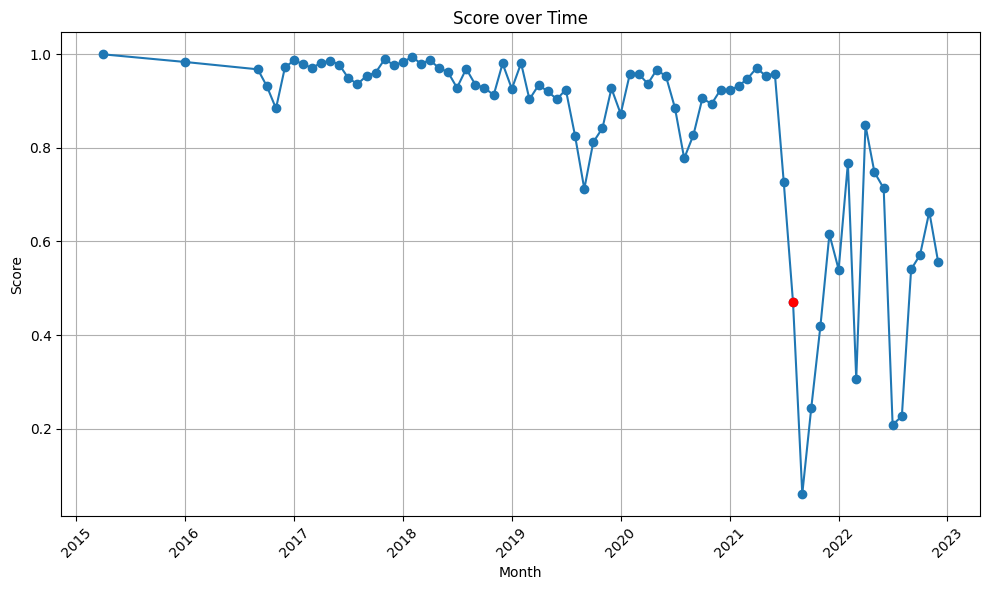



Deforestation Month: 9/2021


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_socre['Month'], monthly_socre['Score'], marker='o')

highlight_index = monthly_socre[monthly_socre['Month'] == max_deforestation_month].index
plt.scatter(monthly_socre.loc[highlight_index - 1, 'Month'],
            monthly_socre.loc[highlight_index - 1, 'Score'],
            color='red', zorder=5, label = 'Deforestation')

plt.title('Score over Time')
plt.xlabel('Month')
plt.ylabel('Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print('\n')
print('Deforestation Month: ' + str(max_deforestation_month.month) + '/' + str(max_deforestation_month.year))